In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from fbprophet import Prophet


In [2]:
df=pd.read_csv("../csv-files/mid-gas-2017-2019.csv",index_col=[0], parse_dates=[0])
df.head(3)

,Price,Volume,Settlement Period,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,SAP,EU_ETS,Gas
datetime,,,,,,,,,,,,,,
2017-01-01 00:00:00,44.90,505.00,1,0.0,Sun,1.0,Jan,2017.0,1.0,1.0,52.0,16.95,1.033832,21.294832
2017-01-01 00:30:00,47.13,559.15,2,0.0,Sun,1.0,Jan,2017.0,1.0,1.0,52.0,16.95,1.033832,21.294832
2017-01-01 01:00:00,45.62,649.35,3,1.0,Sun,1.0,Jan,2017.0,1.0,1.0,52.0,16.95,1.033832,21.294832


In [3]:
df_INDO=pd.read_csv('../csv-files/INDO-2017-2019.csv',index_col=[0],parse_dates=[0])
df_INDO.head(3)

,Settlement_Period,INDO
datetime,,
2017-01-01 00:00:00,1,27239
2017-01-01 00:30:00,2,27814
2017-01-01 01:00:00,3,27453


In [6]:
df=pd.merge(df,df_INDO['INDO'], how='inner', left_index=True, right_index=True)

In [7]:
df.head(3)

,Price,Volume,Settlement Period,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,SAP,EU_ETS,Gas,INDO
datetime,,,,,,,,,,,,,,,
2017-01-01 00:00:00,44.90,505.00,1,0.0,Sun,1.0,Jan,2017.0,1.0,1.0,52.0,16.95,1.033832,21.294832,27239
2017-01-01 00:30:00,47.13,559.15,2,0.0,Sun,1.0,Jan,2017.0,1.0,1.0,52.0,16.95,1.033832,21.294832,27814
2017-01-01 01:00:00,45.62,649.35,3,1.0,Sun,1.0,Jan,2017.0,1.0,1.0,52.0,16.95,1.033832,21.294832,27453


In [10]:
df['Gas'].isna().sum()

0

In [11]:
#Splitting the data:
def split_data(data, split_date):
    return data[data.index <= split_date].copy(), \
           data[data.index >  split_date].copy()

def limit(data, frm, to):
    return data[(data.index>=frm)&(data.index<to)]

In [12]:
df.sort_index(inplace=True)

In [13]:
t = df.Price.copy()
t = t.drop(t.index[t.index.duplicated()])
freq_index = pd.date_range(start=t.index[0], end=t.index[-1], freq='30T')
constructed = pd.Series(index=freq_index, name='Price')
constructed.update(t)
constructed.interpolate(inplace=True)


In [14]:
train = limit(constructed, '2019-01-01', '2019-06-15')
test  = limit(constructed, '2019-06-15', '2019-07-01')
print(train.shape)
print(test.shape)

(7920,)
(768,)


In [15]:
#for gas data
g = df.Gas.copy()
g = g.drop(g.index[g.index.duplicated()])
freq_index = pd.date_range(start=g.index[0], end=g.index[-1], freq='30T')
constructed_g = pd.Series(index=freq_index, name='Gas')
constructed_g.update(g)
constructed_g.interpolate(inplace=True)



In [16]:
train_gas = limit(constructed_g, '2019-01-01', '2019-06-15')
test_gas  = limit(constructed_g, '2019-06-15', '2019-07-01')
print(train_gas.shape)
print(test_gas.shape)

(7920,)
(768,)


In [17]:
#for INDO data
i = df.INDO.copy()
i = i.drop(i.index[i.index.duplicated()])
freq_index = pd.date_range(start=i.index[0], end=i.index[-1], freq='30T')
constructed_i = pd.Series(index=freq_index, name='INDO')
constructed_i.update(i)
constructed_i.interpolate(inplace=True)

In [18]:
train_indo = limit(constructed_i, '2019-01-01', '2019-06-15')
test_indo  = limit(constructed_i, '2019-06-15', '2019-07-01')
print(train_indo.shape)
print(test_indo.shape)

(7920,)
(768,)


In [19]:
from datetime import date

import holidays

In [4]:
holidays= pd.read_csv("../csv-files/generated_holidays.csv")
holidays.head()

,ds,holiday,country,year
0,1995-01-01,Ano Nuevo [New Year's Day],AR,1995
1,1995-02-27,Dia de Carnaval [Carnival's Day],AR,1995
2,1995-02-28,Dia de Carnaval [Carnival's Day],AR,1995
3,1995-03-24,Dia Nacional de la Memoria por la Verdad y la ...,AR,1995
4,1995-04-02,Dia del Veterano y de los Caidos en la Guerra ...,AR,1995


In [21]:
holidays.drop(holidays[holidays['country'] != 'UK'].index, inplace=True)

In [22]:
holidays.drop(holidays[holidays['year'] < 2017].index, inplace=True)


In [23]:
holidays.drop(holidays[holidays['year'] > 2020].index, inplace=True)


In [24]:
holidays.head()

,ds,holiday,country,year
79565,2017-01-01,New Year's Day,UK,2017
79566,2017-01-02,"New Year Holiday [Scotland], New Year's Day (O...",UK,2017
79567,2017-01-03,New Year Holiday [Scotland] (Observed),UK,2017
79568,2017-03-17,St. Patrick's Day [Northern Ireland],UK,2017
79569,2017-04-14,Good Friday,UK,2017


In [25]:
#The Prophet Model With Additional Regressor:
#model_P = Prophet()
model_P = Prophet(weekly_seasonality=True, daily_seasonality=True, yearly_seasonality=False, holidays=holidays)
model_P.add_seasonality(name="monthly", period=30.5, fourier_order=5)
model_P.add_regressor('INDO')
model_P.add_regressor('Gas')
model_P.fit(pd.DataFrame({'ds': train.index, 'y':train, 'INDO': train_indo, 'Gas': train_gas}))


INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [26]:
def populate_gas_val(dt):
   current_date=str(dt.date())
   return df[current_date]['Gas'][0]

future_dates = model_P.make_future_dataframe(periods=test.shape[0],freq='30T')
df2=pd.DataFrame({'ds':df.index, 'INDO':df['INDO']})
future_dates=pd.merge(future_dates, df2, on='ds', how='inner')
future_dates['Gas']=future_dates['ds'].apply(populate_gas_val)
results_P = model_P.predict(future_dates)
#forecast_P = results_P.set_index('ds').yhat

In [27]:
forecast_P = results_P.set_index('ds').yhat

In [28]:
test.head()

2019-06-15 00:00:00    38.94
2019-06-15 00:30:00    39.48
2019-06-15 01:00:00    38.22
2019-06-15 01:30:00    37.19
2019-06-15 02:00:00    40.13
Freq: 30T, Name: Price, dtype: float64

In [29]:
fp=forecast_P.tail(768)

In [30]:
fp.head()

ds
2019-06-15 00:00:00    38.161108
2019-06-15 00:30:00    37.234753
2019-06-15 01:00:00    36.760960
2019-06-15 01:30:00    36.615475
2019-06-15 02:00:00    35.972331
Name: yhat, dtype: float64

In [31]:
forecast_P[train.shape[0]:].shape

(658,)

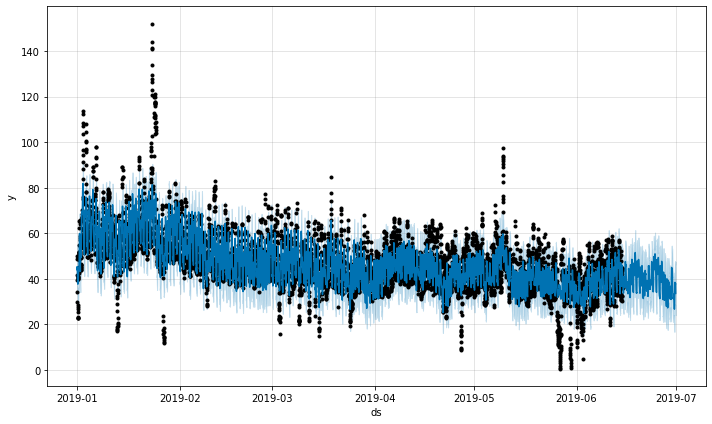

In [32]:
fig=model_P.plot(results_P)

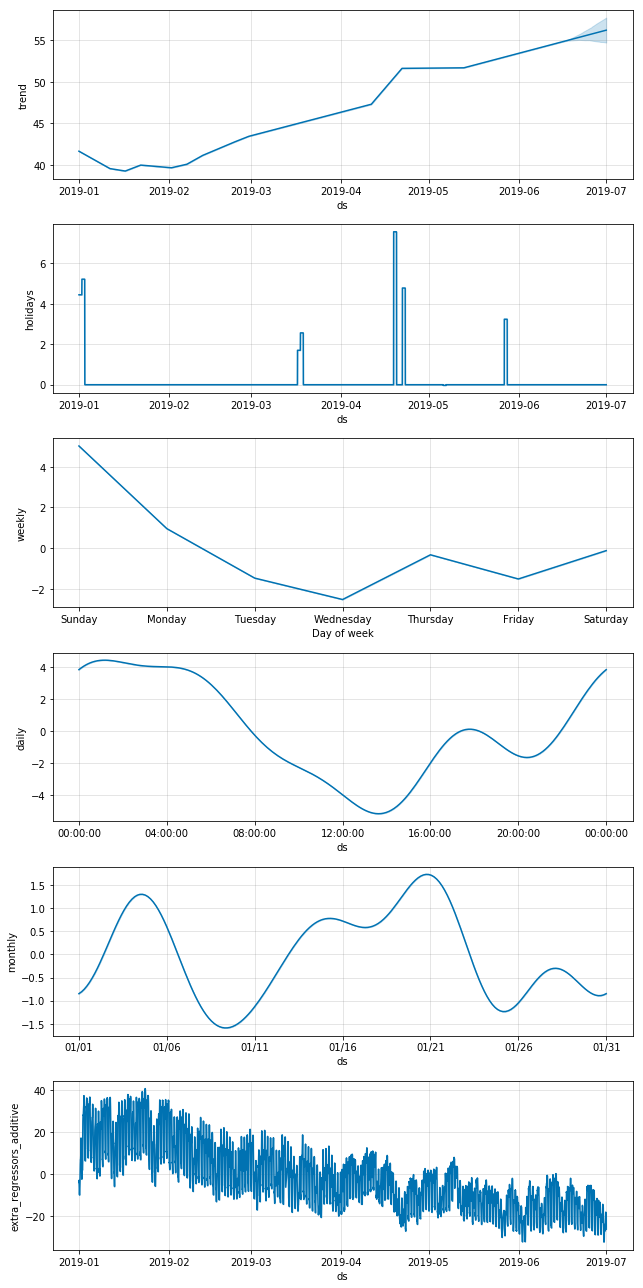

In [115]:
fig2 = model_P.plot_components(results_P)

In [151]:
#Prophet Model  evaluation:
from statsmodels.tools.eval_measures import mse,rmse
from sklearn.metrics import mean_absolute_error

error1 = mse(test, fp)
error2 = rmse(test, fp)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f'MAE Error: {mean_absolute_error(test, fp)}'), 
print(f'MAPE Error: {mean_absolute_percentage_error(test, fp)}')
print(f'MSE Error : {error1:11.10}')
print(f'RMSE Error: {error2:11.10}')
print(fp.shape)
print(test.shape)


MAE Error: 6.622503352707561
MAPE Error: 29.245568650072734
MSE Error : 112.3966585
RMSE Error: 10.60172903
(768,)
(768,)


In [152]:
test_=df[df.index.isin(test.index)].copy()
test_.shape

(768, 15)

In [153]:
df[train.shape[0]:].shape

(35471, 15)

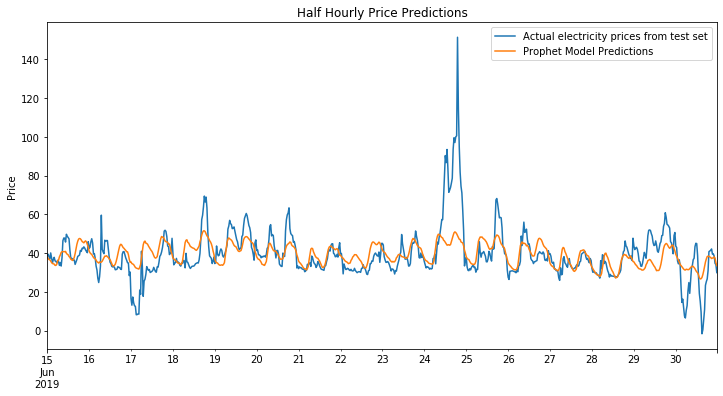

In [38]:
title = 'Half Hourly Price Predictions'
ylabel='Price'
xlabel='' 
ax = test.rename('Actual electricity prices from test set').plot(legend=True,figsize=(12,6),title=title)
forecast_P['2019-06-15':].rename('Prophet Model Predictions').plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);